# Model Evaluation & Interpretability

**Interpretability:** Using **SHAP (SHapley Additive exPlanations)** to understand *which* features drive prices up or down.

**Error Analysis:** Analyzing residuals to detect bias or systematic errors in predictions.

In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')

In [3]:
print("Loading artifacts...")

try:
    # Load the trained model
    model = joblib.load("../models/best_lgbm_model.pkl")
    
    # Load validation data
    X_valid = joblib.load("../data/X_valid_for_eval.joblib")
    y_valid = joblib.load("../data/y_valid_for_eval.joblib")
    
    print("Model and data loaded successfully.")

except FileNotFoundError:
    print("Error: Artifacts not found. Please run '03_Model_Improvement_Geospatial_Optuna.ipynb' first.")

Loading artifacts...
Model and data loaded successfully.


In [4]:
print("Calculating detailed regression metrics...")

# Predictions (Log Scale)
preds_log = model.predict(X_valid)

# Convert back to Original Scale (TL/Currency) for interpretable metrics
y_true_orig = np.expm1(y_valid)
preds_orig = np.expm1(preds_log)

# 1. RMSLE (Kaggle Metric - Log Scale)
rmsle = np.sqrt(mean_squared_error(y_valid, preds_log))

# 2. MAE (Mean Absolute Error - Original Scale)
mae = mean_absolute_error(y_true_orig, preds_orig)

# 3. RMSE (Root Mean Squared Error - Original Scale)
rmse_orig = np.sqrt(mean_squared_error(y_true_orig, preds_orig))

# 4. R2 Score (Variance Explained)
r2 = r2_score(y_true_orig, preds_orig)

# Create a nice DataFrame for display
metrics_df = pd.DataFrame({
    "Metric": ["RMSLE (Log Scale)", "MAE (Original Currency)", "RMSE (Original Currency)", "R2 Score"],
    "Value": [rmsle, mae, rmse_orig, r2],
    "Description": [
        "Kaggle Competition Metric (Lower is better)",
        "Average error in real currency (Lower is better)",
        "Penalizes large errors more than MAE",
        "How well the model fits the data (Closer to 1.0 is better)"
    ]
})

print("\n" + "="*60)
print("MODEL PERFORMANCE REPORT")
print("="*60)
display(metrics_df)

Calculating detailed regression metrics...

MODEL PERFORMANCE REPORT


,Metric,Value,Description
0,RMSLE (Log Scale),0.415359,Kaggle Competition Metric (Lower is better)
1,MAE (Original Currency),944.199005,Average error in real currency (Lower is better)
2,RMSE (Original Currency),1956.827873,Penalizes large errors more than MAE
3,R2 Score,0.613277,How well the model fits the data (Closer to 1....


Calculating SHAP values...


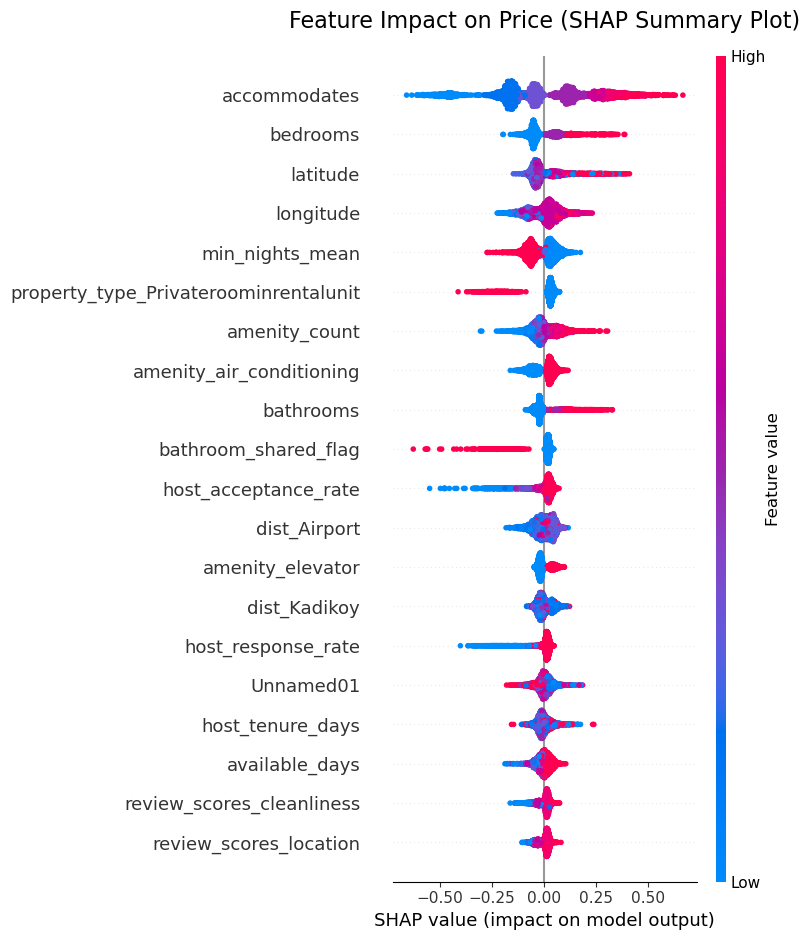

In [5]:
print("Calculating SHAP values...")

# Create Tree Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

# Plot Summary
plt.figure(figsize=(12, 10))
plt.title("Feature Impact on Price (SHAP Summary Plot)", fontsize=16, pad=20)
shap.summary_plot(shap_values, X_valid, max_display=20, show=False)
plt.tight_layout()
plt.show()

Visualizing Errors...


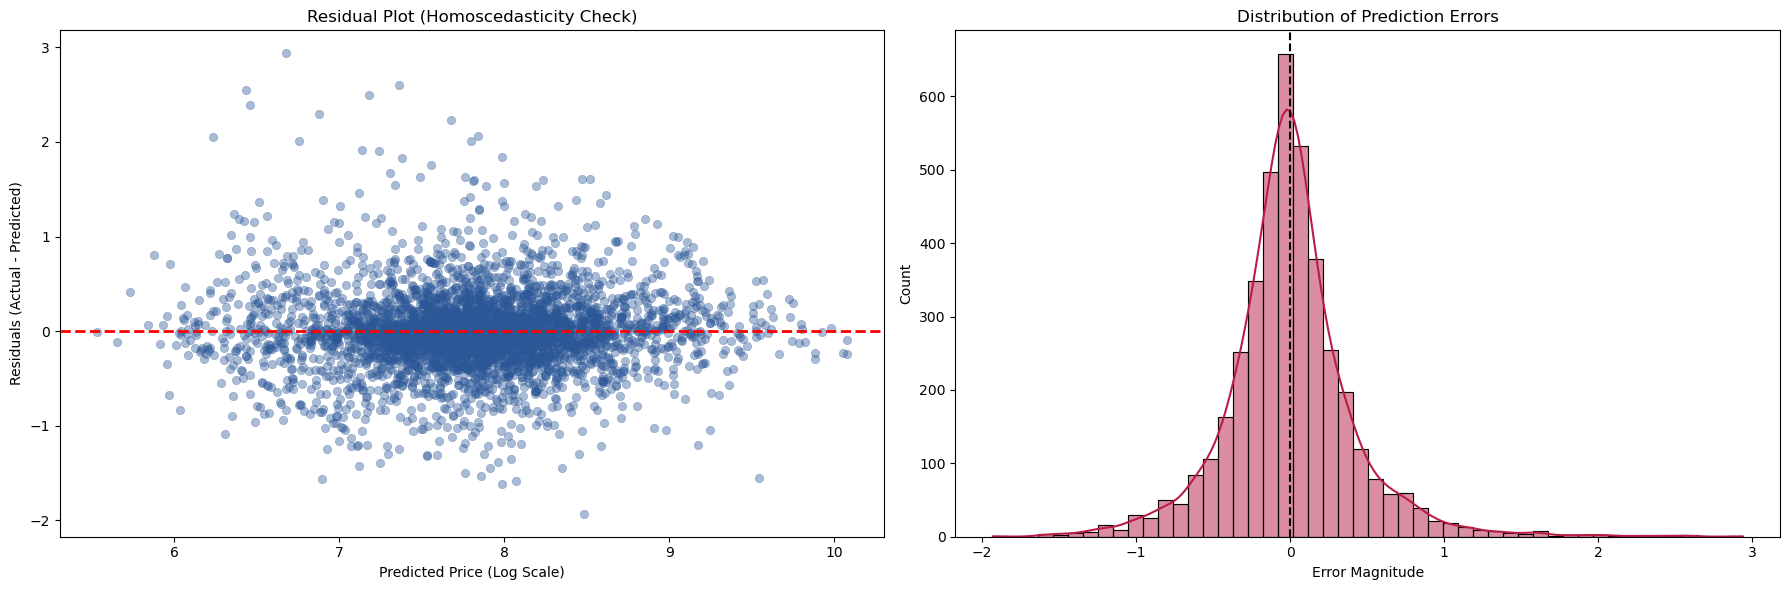

Evaluation completed.


In [6]:
print("Visualizing Errors...")

# Calculate Residuals (Log scale to see distribution better)
residuals = y_valid - preds_log

# Create Plots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# 1. Predicted vs Residuals (Scatter)
sns.scatterplot(x=preds_log, y=residuals, alpha=0.4, color="#2b5797", edgecolor=None, ax=ax[0])
ax[0].axhline(0, color="red", linestyle="--", linewidth=2)
ax[0].set_xlabel("Predicted Price (Log Scale)")
ax[0].set_ylabel("Residuals (Actual - Predicted)")
ax[0].set_title("Residual Plot (Homoscedasticity Check)")

# 2. Error Distribution (Histogram)
sns.histplot(residuals, bins=50, kde=True, color="#b91d47", ax=ax[1])
ax[1].axvline(0, color="k", linestyle="--")
ax[1].set_title("Distribution of Prediction Errors")
ax[1].set_xlabel("Error Magnitude")

plt.tight_layout()
plt.show()

print("Evaluation completed.")